# Installing required libraries

# Imports

In [1]:
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from lightning.pytorch.callbacks import EarlyStopping
from torch.utils.data import DataLoader
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score
)

import pytorch_lightning as pl
from torchvision import datasets, transforms
import torchvision.models as models
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os

import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)
import mlflow
from lightning.pytorch.loggers import MLFlowLogger
import random
from PIL import Image, ImageFile
import numpy as np

torch.set_float32_matmul_precision('medium')
#Using it reduces precision thus makes iteration faster. 
#Training behaviour and code logic remains same.
#Good for experimentation and while building a working min end to end pipeline, can be removed for final training.

/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Configuring MLFlow

In [3]:
mlf_logger = MLFlowLogger(
    experiment_name="AI Generated Image Detector Finalised",
    run_name="resnet34_localfft",
    tracking_uri="http://127.0.0.1:5000"
)


# Dataset Preparation

In [4]:
data_dir = "/home/sanjeet/ai_workspace/AI generated image detector/Data"

## FFT utilities

### (A) Patch extraction

In [5]:
def extract_patches(img, patch_size):
    """
    img: Tensor [C, H, W]
    returns: Tensor [N, C, P, P]
    """
    C, H, W = img.shape
    P = patch_size

    patches = img.unfold(1, P, P).unfold(2, P, P)
    patches = patches.contiguous().view(C, -1, P, P)
    patches = patches.permute(1, 0, 2, 3)
    return patches


### (B) FFT on patches

In [6]:
def fft_patchwise(patches):
    """
    patches: [N, C, P, P]
    returns: [N, C, P, P]
    """
    fft = torch.fft.fft2(patches)
    mag = torch.abs(fft)
    mag = torch.log1p(mag)
    return mag


### (C) Reassemble patches into feature map

In [7]:
def reassemble_patches(patches, img_shape, patch_size):
    """
    patches: [N, C, P, P]
    img_shape: (C, H, W)
    """
    C, H, W = img_shape
    P = patch_size
    nH = H // P
    nW = W // P

    patches = patches.permute(1, 0, 2, 3)
    patches = patches.contiguous().view(C, nH, nW, P, P)
    patches = patches.permute(0, 1, 3, 2, 4)
    return patches.contiguous().view(C, H, W)


## End-to-end Local Patch FFT transform

In [8]:
class LocalPatchFFT:
    def __init__(self, patch_size=32):
        self.patch_size = patch_size

    def __call__(self, img):
        """
        img: Tensor [C, H, W]
        """
        patches = extract_patches(img, self.patch_size)
        patches_fft = fft_patchwise(patches)
        return reassemble_patches(
            patches_fft,
            img.shape,
            self.patch_size
        )

local_fft = LocalPatchFFT()

## Custom Dataset

In [9]:
class MultiGenDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.samples = []
        self.transform = transform

        generators = os.listdir(root_dir)

        for gen in generators:
            gen_path = os.path.join(root_dir, gen, split)
            if not os.path.isdir(gen_path):
                continue

            for cls in ["ai", "nature"]:
                class_dir = os.path.join(gen_path, cls)
                if not os.path.isdir(class_dir):
                    continue

                #Mapping: nature=REAL(0) ai=FAKE(1) 
                label = 1 if cls == "ai" else 0  

                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, label))

        assert len(self.samples) > 0, "Dataset is EMPTY"
        print(f"[{split}] Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        img = local_fft(img)

        return img, label


## Transforms

In [10]:
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),          # ResNet input size                                      # mild, not aggressive
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],          # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])


VAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Lightning DataModule

In [11]:
class MultiGenDatasetModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=2):
        super().__init__()
    
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_dataset = None
        self.test_dataset = None

    def setup(self, stage=None):

        self.train_ds = MultiGenDataset(
            self.data_dir, "train", TRAIN_TRANSFORM
        )
        self.val_ds = MultiGenDataset(
            self.data_dir, "val", VAL_TRANSFORM
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers, #for problem free sanity checking, num_workers = 0 as sanity checking uses val loader
            pin_memory=True,
            persistent_workers=True
        )


## DataModule Initialization

In [12]:
data_module = MultiGenDatasetModule(
    data_dir=data_dir,
    batch_size=96,
    num_workers=4
)

# Loading ResNet34 and Freezing

In [13]:
def load_resnet34_freq_model(
    num_classes=2,
    freeze_layer2=False
):
    """
    ResNet-34 for frequency-domain branch.
    - ImageNet pretrained
    - Early layers frozen
    - Deeper layers trainable

    Args:
        num_classes (int): number of output classes
        freeze_layer2 (bool): whether to freeze layer2 as well

    Returns:
        model (nn.Module)
    """

    # 1. Load pretrained ResNet-34
    model = models.resnet34(
        weights=models.ResNet34_Weights.IMAGENET1K_V1
    )

    # 2. Replace classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # 3. Freeze stem
    for p in model.conv1.parameters():
        p.requires_grad = False
    for p in model.bn1.parameters():
        p.requires_grad = False

    # 4. Freeze layer1
    for p in model.layer1.parameters():
        p.requires_grad = False

    # 5. Optionally freeze layer2
    if freeze_layer2:
        for p in model.layer2.parameters():
            p.requires_grad = False

    return model


# Schedulers and Optimizers

In [14]:
def define_optimizer_and_scheduler(model, learning_rate, weight_decay):
    """
    Defines the optimizer and learning rate scheduler for transfer learning.

    Args:
        model (nn.Module): Model with frozen backbone and trainable head.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization).

    Returns:
        tuple: (optimizer, scheduler)
    """
    # Optimize ONLY trainable parameters
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    optimizer = optim.AdamW(
        trainable_params,
        lr=learning_rate,
        weight_decay=weight_decay
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.1,
        patience=2
    )

    return optimizer, scheduler


# Lightning Module

In [15]:
class AIImageDetector(pl.LightningModule):
    """
    LightningModule for AI-generated vs Real image classification
    using transfer learning with ResNet-50.
    """

    def __init__(self, learning_rate=1e-3,weight_decay=1e-2):
        super().__init__()
        self.save_hyperparameters()
        

        self.model = load_resnet34_freq_model(num_classes=2)


        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = BinaryAccuracy()
        self.val_acc   = BinaryAccuracy()
        self.val_precision = BinaryPrecision()
        self.val_recall = BinaryRecall()
        self.val_f1 = BinaryF1Score()
        
    def forward(self, x):

        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = (probs > 0.5).int()

        acc = self.train_acc(preds, y)

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)

        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = (probs > 0.5).int()

        acc = self.val_acc(preds, y)

        self.val_precision.update(preds, y)
        self.val_recall.update(preds, y)
        self.val_f1.update(preds, y)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)


    def configure_optimizers(self):
        optimizer, scheduler = define_optimizer_and_scheduler(
            self.model,
            self.hparams.learning_rate,
            self.hparams.weight_decay
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }
    def on_validation_epoch_end(self):
        self.log("val_precision", self.val_precision.compute(), prog_bar=True)
        self.log("val_recall", self.val_recall.compute(), prog_bar=True)
        self.log("val_f1", self.val_f1.compute(), prog_bar=True)

        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()



# Configuring Early Stopping

In [16]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_cb = EarlyStopping(
    monitor="val_f1",
    patience=4,
    mode="max",
    verbose=True,
    min_delta = 0.003
)

# Trainer Helper Function

In [17]:
def initialize_trainer(
    num_epochs,
    early_stop_callback,
    progress_bar=True,
    dry_run=False
):
    """
    Runs Lightning training for the CIFake project.

    Returns:
        trainer (pl.Trainer)
        model (pl.LightningModule)
    """

    # Save the best model based on validation loss
    checkpoint_cb = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints",
        filename="best-model"
    )

    callbacks = [early_stop_callback, checkpoint_cb]

    trainer = pl.Trainer(
        max_epochs=num_epochs,
        accelerator="auto",
        devices=1,
        precision="16-mixed",
        callbacks=callbacks,
        logger=mlf_logger,
        enable_progress_bar=progress_bar,
        enable_model_summary=False,
        fast_dev_run=dry_run,
        num_sanity_val_steps = 0
    )


    return trainer


# Model Initialization 

In [18]:
model = AIImageDetector(
    learning_rate=1e-3,
    weight_decay=1e-2
)

# Trainer Configuration

In [19]:
trainer = initialize_trainer(
    num_epochs=50,
    early_stop_callback=early_stop_cb,
    progress_bar=True,
    dry_run=False
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


# MLflow Logger

In [20]:
# Gather hyperparameters from various objects
hparams_to_log = {
    "model_name": "resnet34",
    "architecture": "ResNet34 (ImageNet pre-trained)",
    "num_classes": model.model.fc.out_features,
    "freeze_layer2": False, # As per load_resnet34_freq_model default in this setup
    "fft_patch_size": local_fft.patch_size,
    "img_size": 224,
    "learning_rate": model.hparams.learning_rate,
    "weight_decay": model.hparams.weight_decay,
    "optimizer": "AdamW",

    "data_batch_size": data_module.batch_size,
    "data_num_workers": data_module.num_workers,
    "image_input_size": TRAIN_TRANSFORM.transforms[0].size[0],

    "early_stopping_monitor": early_stop_cb.monitor,
    "early_stopping_patience": early_stop_cb.patience,
    "early_stopping_mode": early_stop_cb.mode,
    "early_stopping_min_delta": early_stop_cb.min_delta,

    "trainer_max_epochs": trainer.max_epochs,
    "trainer_precision": trainer.precision,
    "trainer_accelerator": trainer.accelerator,
    "device": "RTX 3050",
    
    "notebook_path": "/home/sanjeet/ai_workspace/AI generated image detector/resnet34-localfft_training_v1.ipynb"
}

# Log to the current active run (the training run)
with mlflow.start_run(run_id=trainer.logger.run_id):
    mlflow.log_params(hparams_to_log)
    print("Hyperparameters logged to MLflow.")

Experiment with name AI Generated Image Detector Finalised not found. Creating it.


Hyperparameters logged to MLflow.
🏃 View run resnet34_localfft at: http://127.0.0.1:5000/#/experiments/2/runs/f59dc099df0a447ebeb7b60a36dc9cc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# Model Training

In [21]:
trainer.fit(model, datamodule=data_module)

/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/sanjeet/ai_workspace/AI generated image detector/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[train] Loaded 28000 samples
[val] Loaded 7000 samples
Epoch 0: 100%|██████████| 292/292 [03:01<00:00,  1.61it/s, v_num=9cc0, train_loss_step=0.138, train_acc_step=0.953, val_loss=0.238, val_acc=0.894, val_precision=0.843, val_recall=0.968, val_f1=0.901, train_loss_epoch=0.348, train_acc_epoch=0.844]

Metric val_f1 improved. New best score: 0.901


Epoch 1: 100%|██████████| 292/292 [02:21<00:00,  2.06it/s, v_num=9cc0, train_loss_step=0.275, train_acc_step=0.891, val_loss=0.153, val_acc=0.937, val_precision=0.934, val_recall=0.941, val_f1=0.937, train_loss_epoch=0.180, train_acc_epoch=0.927] 

Metric val_f1 improved by 0.036 >= min_delta = 0.003. New best score: 0.937


Epoch 3: 100%|██████████| 292/292 [02:08<00:00,  2.27it/s, v_num=9cc0, train_loss_step=0.0842, train_acc_step=0.953, val_loss=0.126, val_acc=0.950, val_precision=0.926, val_recall=0.979, val_f1=0.952, train_loss_epoch=0.100, train_acc_epoch=0.961]

Metric val_f1 improved by 0.014 >= min_delta = 0.003. New best score: 0.952


Epoch 5: 100%|██████████| 292/292 [02:17<00:00,  2.12it/s, v_num=9cc0, train_loss_step=0.0278, train_acc_step=0.984, val_loss=0.113, val_acc=0.958, val_precision=0.967, val_recall=0.950, val_f1=0.958, train_loss_epoch=0.0611, train_acc_epoch=0.977] 

Metric val_f1 improved by 0.006 >= min_delta = 0.003. New best score: 0.958


Epoch 9: 100%|██████████| 292/292 [02:21<00:00,  2.06it/s, v_num=9cc0, train_loss_step=0.00343, train_acc_step=1.000, val_loss=0.0967, val_acc=0.970, val_precision=0.979, val_recall=0.961, val_f1=0.970, train_loss_epoch=0.0127, train_acc_epoch=0.996]

Metric val_f1 improved by 0.012 >= min_delta = 0.003. New best score: 0.970


Epoch 11: 100%|██████████| 292/292 [02:08<00:00,  2.28it/s, v_num=9cc0, train_loss_step=0.000259, train_acc_step=1.000, val_loss=0.103, val_acc=0.973, val_precision=0.976, val_recall=0.971, val_f1=0.973, train_loss_epoch=0.00305, train_acc_epoch=0.999] 

Metric val_f1 improved by 0.003 >= min_delta = 0.003. New best score: 0.973


Epoch 15: 100%|██████████| 292/292 [02:00<00:00,  2.42it/s, v_num=9cc0, train_loss_step=2.96e-5, train_acc_step=1.000, val_loss=0.122, val_acc=0.973, val_precision=0.981, val_recall=0.965, val_f1=0.973, train_loss_epoch=0.00139, train_acc_epoch=1.000] 

Monitored metric val_f1 did not improve in the last 4 records. Best score: 0.973. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 292/292 [02:00<00:00,  2.42it/s, v_num=9cc0, train_loss_step=2.96e-5, train_acc_step=1.000, val_loss=0.122, val_acc=0.973, val_precision=0.981, val_recall=0.965, val_f1=0.973, train_loss_epoch=0.00139, train_acc_epoch=1.000]
🏃 View run resnet34_localfft at: http://127.0.0.1:5000/#/experiments/2/runs/f59dc099df0a447ebeb7b60a36dc9cc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# Saving Model

In [22]:
best_ckpt_path = trainer.checkpoint_callback.best_model_path

In [23]:
ckpt = torch.load(best_ckpt_path, map_location="cpu")

state_dict = ckpt["state_dict"]

model.load_state_dict(state_dict)
device = torch.device("cuda")
model.to(device)
model.eval()

/tmp/ipykernel_875/2933482019.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_ckpt_path, map_location="cpu")


AIImageDetector(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [24]:
torch.save(
    model.state_dict(),
    "resnet34_localfft_v1.pth"
)

# Logging Model

In [25]:
import mlflow.pytorch

# Ensure we log to the currently active run (the training run)
# If the run has already ended, we can restart it using its run_id
with mlflow.start_run(run_id=trainer.logger.run_id):
    print(f"Logging model to existing MLflow Run ID: {mlflow.active_run().info.run_id}")
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path="resnet34_localfft_model",
        registered_model_name="Synapse-7"
    )

    print("Trained model logged to MLflow within the training run.")

2026/02/13 04:21:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging model to existing MLflow Run ID: f59dc099df0a447ebeb7b60a36dc9cc0


2026/02/13 04:21:01 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/13 04:21:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/13 04:21:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version la

Trained model logged to MLflow within the training run.
🏃 View run resnet34_localfft at: http://127.0.0.1:5000/#/experiments/2/runs/f59dc099df0a447ebeb7b60a36dc9cc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# Graphs for analysis

## Train vs Validation Accuracy

MLflow Run ID: f59dc099df0a447ebeb7b60a36dc9cc0
Number of epochs found in MLflow logs: 16


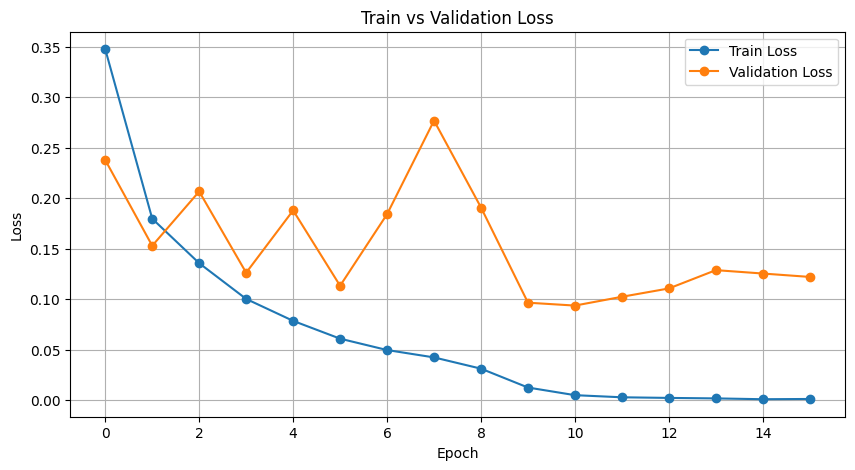

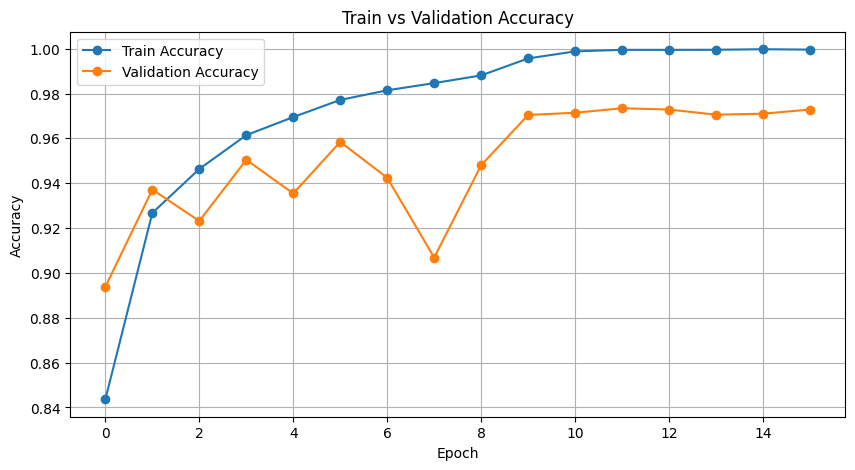

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import mlflow

# Get the run ID from the logger after training
run_id = trainer.logger.run_id
print(f"MLflow Run ID: {run_id}")

# Fetch metrics for the specific run
client = mlflow.tracking.MlflowClient()

# Fetch historical metrics for plotting - corrected metric names for training
train_loss_history = client.get_metric_history(run_id, 'train_loss_epoch')
val_loss_history = client.get_metric_history(run_id, 'val_loss')
train_acc_history = client.get_metric_history(run_id, 'train_acc_epoch')
val_acc_history = client.get_metric_history(run_id, 'val_acc')

# Extract values and epochs
train_loss = [m.value for m in train_loss_history]
val_loss = [m.value for m in val_loss_history]
train_acc = [m.value for m in train_acc_history]
val_acc = [m.value for m in val_acc_history]

# Assuming all metric histories have the same length (number of epochs)
num_epochs = len(train_loss)
epochs = range(num_epochs)
print(f"Number of epochs found in MLflow logs: {num_epochs}")

if num_epochs == 0:
    print("No epoch data found to plot. Please ensure training completed successfully and logged metrics.")
elif num_epochs == 1:
    print("Only one epoch found. Plotting a single point.")

# Plot Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o') # Added marker
plt.plot(epochs, val_loss, label='Validation Loss', marker='o') # Added marker
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Train vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o') # Added marker
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o') # Added marker
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Evaluation

In [ ]:
threshold = 0.82

In [ ]:
val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


val_ds = MultiGenDataset(
    root_dir=data_dir,
    split="val",
    transform=val_tf
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4
)


[val] Loaded 7000 samples


## Validation / Inference Loop for Evaluation

In [ ]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        threshold = threshold

        
        p_fake = probs[:, 1]          # Probability of Fake (AI) class is used as decision reference.
        preds = (p_fake >= threshold).long()

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_probs.append(probs[:, 1].cpu()) # Collect probabilities for the 'AI' class

In [ ]:
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
y_prob = torch.cat(all_probs).numpy()

## Confusion Matrix

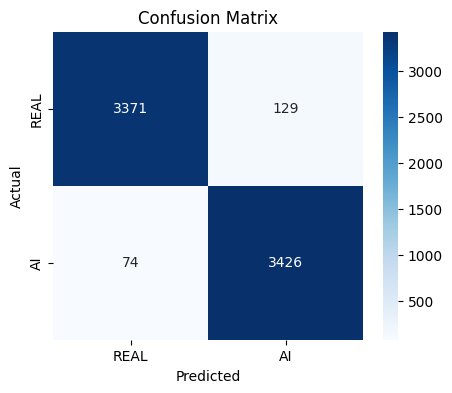

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["REAL", "AI"],
    yticklabels=["REAL", "AI"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Classification Report

In [ ]:
print("New report:")

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["REAL", "AI"]
    )
)


## Generator-wise Evaluation

### Updated MultiGenDataset class
MultiGenDataset now also returns gen_name.

In [ ]:
class MultiGenDatasetv2(Dataset):
    def __init__(self, root_dir, split="val", transform=None):
        self.samples = []
        self.transform = transform

        generators = os.listdir(root_dir)

        for gen in generators:
            gen_path = os.path.join(root_dir, gen, split)
            if not os.path.isdir(gen_path):
                continue

            for cls in ["ai", "nature"]:
                class_dir = os.path.join(gen_path, cls)
                if not os.path.isdir(class_dir):
                    continue

                #Mapping: nature=REAL(0) ai=FAKE(1)
                label = 1 if cls == "ai" else 0

                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    # Store generator name along with path and label
                    self.samples.append((img_path, label, gen))

        assert len(self.samples) > 0, "Dataset is EMPTY"
        print(f"[{split}] Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, gen_name = self.samples[idx] # Unpack gen_name
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img) # img is now a [C, H, W] tensor [0, 1]
        img_fft = local_fft(img)
        
        return img_fft, label, gen_name # Return gen_name as well

### Updated DataLoader

In [ ]:
gen_val_ds = MultiGenDatasetv2(
    root_dir="/home/sanjeet/ai_workspace/AI generated image detector/Data",
    split="val",
    transform=val_tf
)

gen_val_loader = DataLoader(
    gen_val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

[val] Loaded 7000 samples


In [ ]:
from collections import defaultdict

gen_stats = defaultdict(lambda: {"y": [], "p": []})

with torch.no_grad():
    for imgs, labels, gen_names in gen_val_loader:  # gen_names must be returned by dataset
        imgs = imgs.to(device)
   
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        threshold = threshold # Use the same updated threshold

        p_fake = probs[:, 1]
        preds = (p_fake >= threshold).long()

        for g, y, p in zip(gen_names, labels, preds):
            gen_stats[g]["y"].append(y.item())
            gen_stats[g]["p"].append(p.item())

In [ ]:
for gen, d in gen_stats.items():
    print(f"\nGenerator: {gen}")
    print(classification_report(d["y"], d["p"]))



Generator: imagenet_glide
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       500
           1       0.94      0.99      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


Generator: imagenet_ai_0508_adm
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       500
           1       0.97      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Generator: imagenet_ai_0424_sdv5
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       500
           1       0.96      0.99      0.98       500

    accuracy                           0.97      1000
   macro avg       0.98      0.97 

## Threshold Sweeping (Decision boundary stress test)

Generated 99 thresholds from 0.01 to 0.99.


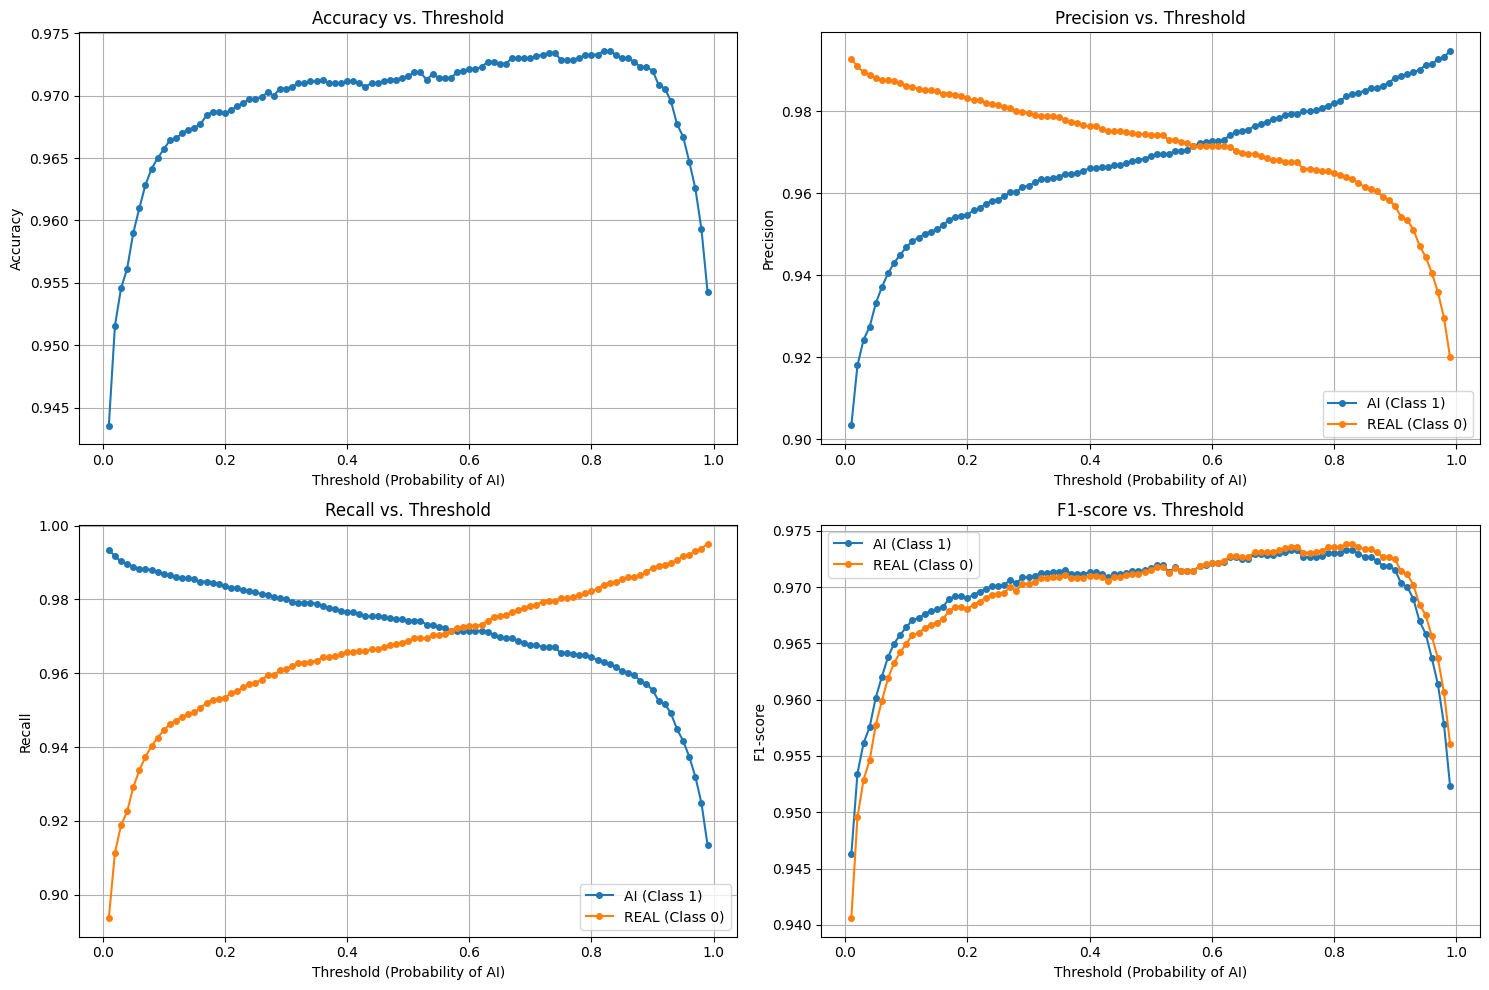


--- Impact of different thresholds on model performance ---


Overall highest metrics: 

Maximum overall accuracy of 0.9736 is achieved at threshold 0.82.
Highest Overall Precision (macro avg) (0.9738) is at threshold 0.83.
Highest Overall Recall (macro avg) (0.9736) is at threshold 0.82.
Highest Overall F1-score (macro avg) (0.9736) is at threshold 0.82.

Classwise highest metrics: 

Highest Precision for AI class (0.9947) is at threshold 0.99.
Highest Recall for AI class (0.9934) is at threshold 0.01.
Highest F1-score for AI class (0.9733) is at threshold 0.82.
Highest Precision for REAL class (0.9927) is at threshold 0.01.
Highest Recall for REAL class (0.9951) is at threshold 0.99.
Highest F1-score for REAL class (0.9739) is at threshold 0.83.

Observations:
 - As the threshold increases, precision for AI class generally increases (fewer false positives) while recall decreases (more false negatives).
 - Conversely, as the threshold increases, recall for REAL class generally increa

In [ ]:
# --- Decision boundary stress test --- #

thresholds = np.arange(0.01, 1.00, 0.01)
print(f"Generated {len(thresholds)} thresholds from {thresholds.min()} to {thresholds.max()}.")

# Initialize lists to store metrics for plotting
accuracy_scores = []
precision_ai = []
recall_ai = []
f1_ai = []
precision_real = []
recall_real = []
f1_real = []

# New lists for overall (macro avg) metrics
overall_precision = []
overall_recall = []
overall_f1 = []

# Iterate through each threshold
for t in thresholds:
    # Calculate predictions based on the current threshold
    # Class 1 (AI) if probability of AI is >= threshold, else Class 0 (REAL)
    y_pred_thresholded = (y_prob >= t).astype(int)

    # Generate classification report for the current threshold
    report = classification_report(
        y_true,
        y_pred_thresholded,
        target_names=["REAL", "AI"],
        output_dict=True,
        zero_division=0 # Handle cases where precision/recall might be zero
    )

    # Store overall accuracy
    accuracy_scores.append(report['accuracy'])

    # Store metrics for AI class (class 1)
    precision_ai.append(report['AI']['precision'])
    recall_ai.append(report['AI']['recall'])
    f1_ai.append(report['AI']['f1-score'])

    # Store metrics for REAL class (class 0)
    precision_real.append(report['REAL']['precision'])
    recall_real.append(report['REAL']['recall'])
    f1_real.append(report['REAL']['f1-score'])

    # Store overall (macro avg) metrics
    overall_precision.append(report['macro avg']['precision'])
    overall_recall.append(report['macro avg']['recall'])
    overall_f1.append(report['macro avg']['f1-score'])

# --- Plotting the results --- #

plt.figure(figsize=(15, 10))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(thresholds, accuracy_scores, marker='o', linestyle='-', markersize=4)
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(thresholds, precision_ai, label='AI (Class 1)', marker='o', linestyle='-', markersize=4)
plt.plot(thresholds, precision_real, label='REAL (Class 0)', marker='o', linestyle='-', markersize=4)
plt.title('Precision vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(thresholds, recall_ai, label='AI (Class 1)', marker='o', linestyle='-', markersize=4)
plt.plot(thresholds, recall_real, label='REAL (Class 0)', marker='o', linestyle='-', markersize=4)
plt.title('Recall vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# Plot F1-score
plt.subplot(2, 2, 4)
plt.plot(thresholds, f1_ai, label='AI (Class 1)', marker='o', linestyle='-', markersize=4)
plt.plot(thresholds, f1_real, label='REAL (Class 0)', marker='o', linestyle='-', markersize=4)
plt.title('F1-score vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Summary of Impact --- #

print("\n--- Impact of different thresholds on model performance ---\n")

print("\nOverall highest metrics: \n")
optimal_threshold_idx_acc = np.argmax(accuracy_scores)
optimal_threshold_acc = thresholds[optimal_threshold_idx_acc]
max_accuracy = accuracy_scores[optimal_threshold_idx_acc]
print(f"Maximum overall accuracy of {max_accuracy:.4f} is achieved at threshold {optimal_threshold_acc:.2f}.")

# Overall (macro avg) metrics
optimal_threshold_idx_overall_prec = np.argmax(overall_precision)
optimal_threshold_overall_prec = thresholds[optimal_threshold_idx_overall_prec]
max_overall_prec = overall_precision[optimal_threshold_idx_overall_prec]
print(f"Highest Overall Precision (macro avg) ({max_overall_prec:.4f}) is at threshold {optimal_threshold_overall_prec:.2f}.")

optimal_threshold_idx_overall_rec = np.argmax(overall_recall)
optimal_threshold_overall_rec = thresholds[optimal_threshold_idx_overall_rec]
max_overall_rec = overall_recall[optimal_threshold_idx_overall_rec]
print(f"Highest Overall Recall (macro avg) ({max_overall_rec:.4f}) is at threshold {optimal_threshold_overall_rec:.2f}.")

optimal_threshold_idx_overall_f1 = np.argmax(overall_f1)
optimal_threshold_overall_f1 = thresholds[optimal_threshold_idx_overall_f1]
max_overall_f1 = overall_f1[optimal_threshold_idx_overall_f1]
print(f"Highest Overall F1-score (macro avg) ({max_overall_f1:.4f}) is at threshold {optimal_threshold_overall_f1:.2f}.")

print("\nClasswise highest metrics: \n")
# Class-specific metrics (already present, keeping for completeness)
optimal_threshold_idx_prec_ai = np.argmax(precision_ai)
optimal_threshold_prec_ai = thresholds[optimal_threshold_idx_prec_ai]
max_prec_ai = precision_ai[optimal_threshold_idx_prec_ai]
print(f"Highest Precision for AI class ({max_prec_ai:.4f}) is at threshold {optimal_threshold_prec_ai:.2f}.")

optimal_threshold_idx_rec_ai = np.argmax(recall_ai)
optimal_threshold_rec_ai = thresholds[optimal_threshold_idx_rec_ai]
max_rec_ai = recall_ai[optimal_threshold_idx_rec_ai]
print(f"Highest Recall for AI class ({max_rec_ai:.4f}) is at threshold {optimal_threshold_rec_ai:.2f}.")

optimal_threshold_idx_f1_ai = np.argmax(f1_ai)
optimal_threshold_f1_ai = thresholds[optimal_threshold_idx_f1_ai]
max_f1_ai = f1_ai[optimal_threshold_idx_f1_ai]
print(f"Highest F1-score for AI class ({max_f1_ai:.4f}) is at threshold {optimal_threshold_f1_ai:.2f}.")

optimal_threshold_idx_prec_real = np.argmax(precision_real)
optimal_threshold_prec_real = thresholds[optimal_threshold_idx_prec_real]
max_prec_real = precision_real[optimal_threshold_idx_prec_real]
print(f"Highest Precision for REAL class ({max_prec_real:.4f}) is at threshold {optimal_threshold_prec_real:.2f}.")

optimal_threshold_idx_rec_real = np.argmax(recall_real)
optimal_threshold_rec_real = thresholds[optimal_threshold_idx_rec_real]
max_rec_real = recall_real[optimal_threshold_idx_rec_real]
print(f"Highest Recall for REAL class ({max_rec_real:.4f}) is at threshold {optimal_threshold_rec_real:.2f}.")

optimal_threshold_idx_f1_real = np.argmax(f1_real)
optimal_threshold_f1_real = thresholds[optimal_threshold_idx_f1_real]
max_f1_real = f1_real[optimal_threshold_idx_f1_real]
print(f"Highest F1-score for REAL class ({max_f1_real:.4f}) is at threshold {optimal_threshold_f1_real:.2f}.")

print("\nObservations:")
print(" - As the threshold increases, precision for AI class generally increases (fewer false positives) while recall decreases (more false negatives).")
print(" - Conversely, as the threshold increases, recall for REAL class generally increases while precision decreases.")
print(" - The choice of an optimal threshold depends on the specific goals of the application (e.g., minimizing false positives for AI, or minimizing false negatives for REAL).")


## Generator Wise Testing (Chi squared statistics)

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Prepare data for Chi-squared test
# We want to see if the proportion of correct/incorrect classifications
# is independent of the generator.

contingency_table_data = []
generator_names = []

for gen, data in gen_stats.items():
    generator_names.append(gen)
    true_labels = np.array(data["y"])
    pred_labels = np.array(data["p"])

    correct_predictions = np.sum(true_labels == pred_labels)
    incorrect_predictions = np.sum(true_labels != pred_labels)

    contingency_table_data.append([correct_predictions, incorrect_predictions])

# Convert to a pandas DataFrame for better visualization (optional, but good for inspection)
contingency_df = pd.DataFrame(
    contingency_table_data,
    index=generator_names,
    columns=["Correct", "Incorrect"]
)

print("Contingency Table:")
display(contingency_df)

# Perform Chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_df)

print(f"\nChi-squared statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in classification performance across generators (reject H0).")
else:
    print("There is no statistically significant difference in classification performance across generators (fail to reject H0).")


Contingency Table:


,Correct,Incorrect
imagenet_glide,968,32
imagenet_ai_0508_adm,981,19
imagenet_ai_0424_sdv5,975,25
imagenet_midjourney,946,54
imagenet_ai_0424_wukong,967,33
imagenet_ai_0419_biggan,984,16
imagenet_ai_0419_vqdm,976,24



Chi-squared statistic: 34.0921
P-value: 0.0000
Degrees of Freedom: 6
There is a statistically significant difference in classification performance across generators (reject H0).


## Calibration Analysis

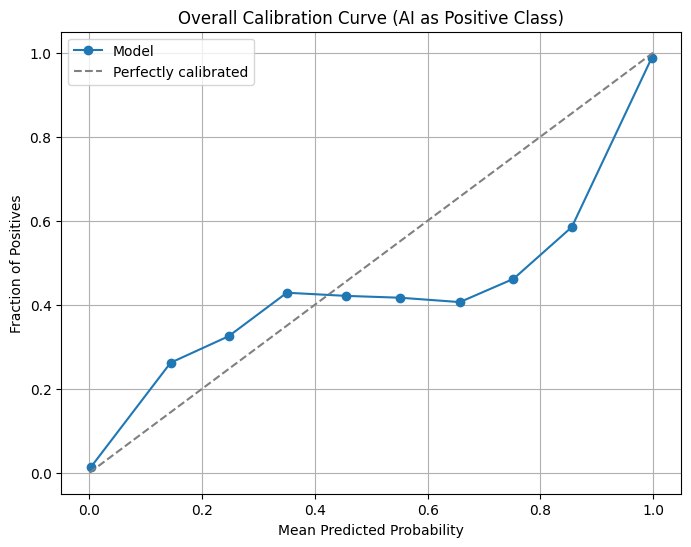

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10, title='Calibration Curve'):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

    fig, ax = plt.subplots(figsize=(8, 6)) # Create figure and axes
    ax.plot(prob_pred, prob_true, marker='o', label='Model')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    return fig # Return the figure object

fig_calibration = plot_calibration_curve(y_true, y_prob, title='Overall Calibration Curve (AI as Positive Class)')

## Score distribution analysis

In [ ]:
ai_probs = y_prob[y_true == 1]
real_probs = y_prob[y_true == 0]

plt.figure(figsize=(10, 6))
plt.hist(ai_probs, bins=50, alpha=0.6, label="AI", color='red')
plt.hist(real_probs, bins=50, alpha=0.6, label="REAL", color='blue')
plt.xlabel("Predicted Probability of AI (1)")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()


## Error probability statistics

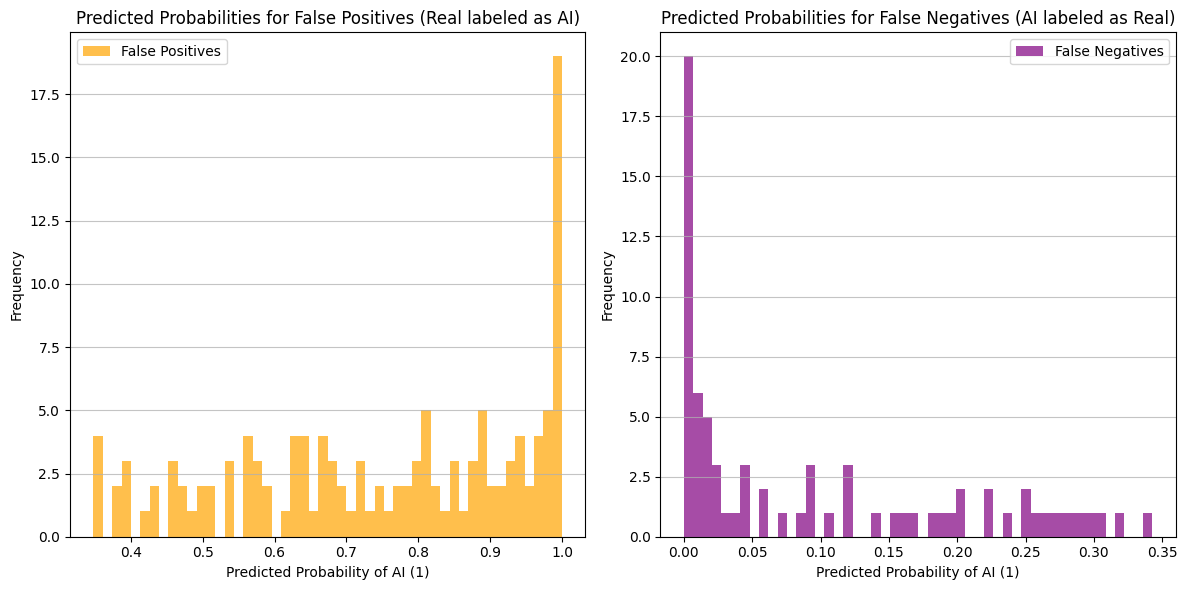

In [ ]:
false_pos = np.where((y_true == 0) & (y_pred == 1))[0]
false_neg = np.where((y_true == 1) & (y_pred == 0))[0]

# Probabilities for false positives (Actual REAL, Predicted AI)
fp_probs = y_prob[false_pos]

# Probabilities for false negatives (Actual AI, Predicted REAL)
fn_probs = y_prob[false_neg]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fp_probs, bins=50, alpha=0.7, color='orange', label='False Positives')
plt.title('Predicted Probabilities for False Positives (Real labeled as AI)')
plt.xlabel('Predicted Probability of AI (1)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
plt.hist(fn_probs, bins=50, alpha=0.7, color='purple', label='False Negatives')
plt.title('Predicted Probabilities for False Negatives (AI labeled as Real)')
plt.xlabel('Predicted Probability of AI (1)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# AI -> Positive   Real -> Negative

# Logging Evaluation Metrics to MLflow

In [ ]:
from collections import defaultdict # Keep for gen_stats processing
import io

# --- MLflow Logging --- #
# This section assumes the following variables are already available from previous cell executions:
# - y_true: Ground truth labels
# - y_pred: Predicted labels
# - y_prob: Predicted probabilities for the positive class (AI)
# - gen_stats: Dictionary containing generator-wise true and predicted labels
# - device: The device (e.g., 'cuda' or 'cpu') where the model is loaded
# - model: The trained model in eval() mode
# - val_tf: Validation transforms
# - data_dir: Path to the dataset
# - MultiGenDatasetv2: Class for generator-wise dataset (from cell TVnY0LgwPQWS)

# Start MLflow run for logging evaluation metrics
# IMPORTANT: Log to the SAME run as the training run (trainer.logger.run_id)
with mlflow.start_run(run_id=trainer.logger.run_id):
    print(f"Logging evaluation metrics to existing MLflow Run ID: {mlflow.active_run().info.run_id}")

    # --- Log Confusion Matrix ---
    # Assuming cm is computed from y_true, y_pred which are results of prior cells.
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["REAL", "AI"],
        yticklabels=["REAL", "AI"],
        ax=ax_cm
    )
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("Actual")
    ax_cm.set_title("Confusion Matrix")
    mlflow.log_figure(fig_cm, "confusion_matrix.png")
    plt.close(fig_cm) # Close the figure to prevent display in notebook unless desired
    print("Logged Confusion Matrix to MLflow.")

    # --- Log Overall Classification Report ---
    # Assuming y_true, y_pred are available from prior cells.
    report_str = classification_report(
        y_true,
        y_pred,
        target_names=["REAL", "AI"]
    )
    mlflow.log_text(report_str, "classification_report.txt")
    print("Logged Overall Classification Report to MLflow.")
    print("\nOverall Classification Report:\n", report_str)

    # --- Log Generator-wise Classification Report ---
    # This part assumes gen_stats is already populated from previous cell executions (e.g., TVnY0LgwPQWS).
    # If not, the previous cells for `MultiGenDatasetv2` and data loading to fill `gen_stats` must be run.

    gen_report_buffer = io.StringIO()
    for gen, d in gen_stats.items():
        gen_report_buffer.write(f"\nGenerator: {gen}\n")
        gen_report_buffer.write(classification_report(d["y"], d["p"]))
        gen_report_buffer.write("\n")

    mlflow.log_text(gen_report_buffer.getvalue(), "generator_wise_classification_report.txt")
    print("Logged Generator-wise Classification Report to MLflow.")
    print("\nGenerator-wise Classification Report:\n", gen_report_buffer.getvalue())

print("MLflow logging complete for evaluation metrics.")

Logging evaluation metrics to existing MLflow Run ID: f59dc099df0a447ebeb7b60a36dc9cc0
Logged Confusion Matrix to MLflow.
Logged Overall Classification Report to MLflow.

Overall Classification Report:
               precision    recall  f1-score   support

        REAL       0.98      0.96      0.97      3500
          AI       0.96      0.98      0.97      3500

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000

Logged Generator-wise Classification Report to MLflow.

Generator-wise Classification Report:
 
Generator: imagenet_glide
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       500
           1       0.94      0.99      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


Generator: imagenet_

# Logging other useful materials

## Dataset documentation

In [ ]:
data_organization = '/home/sanjeet/ai_workspace/AI generated image detector/miscellaneous/dataset_organization.jpeg' # Or the full path to your screenshot
dataset_link = "https://www.kaggle.com/datasets/yangsangtai/tiny-genimage"
with mlflow.start_run(run_id=trainer.logger.run_id): # Log to the same run
    mlflow.log_artifact(data_organization, artifact_path='dataset_documentation')
    mlflow.log_param("dataset_link", dataset_link)
    print(f"Logged dataset explorer screenshot from '{data_organization}' to MLflow.")


Logged dataset explorer screenshot from '/home/sanjeet/ai_workspace/AI generated image detector/miscellaneous/dataset_organization.jpeg' to MLflow.
🏃 View run resnet34_localfft at: http://127.0.0.1:5000/#/experiments/2/runs/f59dc099df0a447ebeb7b60a36dc9cc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## ROC AUC curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Assuming y_true and y_prob are already available from previous evaluation steps

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
ax_roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Receiver Operating Characteristic')
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Log to the existing MLflow run
with mlflow.start_run(run_id=trainer.logger.run_id):
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_figure(fig_roc, "roc_curve.png")
    print(f"Logged ROC AUC score: {roc_auc:.4f}")
    print("Logged ROC curve plot to MLflow.")

plt.close(fig_roc) # Close the figure to prevent display in notebook unless desired

Logged ROC AUC score: 0.9965
Logged ROC curve plot to MLflow.
🏃 View run resnet34_localfft at: http://127.0.0.1:5000/#/experiments/2/runs/f59dc099df0a447ebeb7b60a36dc9cc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## Calibration curve

In [ ]:
# Plot calibration curve for the entire dataset
fig_calibration = plot_calibration_curve(y_true, y_prob, title='Overall Calibration Curve (AI as Positive Class)')

# Log to the existing MLflow run
with mlflow.start_run(run_id=trainer.logger.run_id):
    mlflow.log_figure(fig_calibration, "calibration_curve.png")
    print("Logged calibration curve plot to MLflow.")

plt.close(fig_calibration) # Close the figure to prevent display in notebook unless desired

Logged calibration curve plot to MLflow.
🏃 View run resnet34_localfft at: http://127.0.0.1:5000/#/experiments/2/runs/f59dc099df0a447ebeb7b60a36dc9cc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
